In [1]:
import sys
from pathlib import Path
import pickle

sys.path.append('..')
from ml_prod.starter.train_model import read_data, Model, process_data, normalize_text, get_encoder_dict
from ml_prod.starter import common

In [2]:
import pandas as pd
pd.options.display.width = 2500
pd.options.display.max_columns = 40

In [3]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# for details on the plot, see https://github.com/dssg/aequitas

# Preliminary

## Load model

In [4]:
model = Model()
model.load(common.path_model / 'model.pkl')

C:\software\Anaconda\envs\mlprod\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load feature and label encoders

In [5]:
encoder_paths = list(Path(common.path_model).glob("enc*.pkl"))
encoder_dict = {}
for file in encoder_paths:
    feat = file.with_suffix('').name.split("enc_", 1)[1]
    with open(file, 'rb') as enc_file:
        temp_enc = pickle.load(enc_file)
    encoder_dict.update({feat: temp_enc})

C:\software\Anaconda\envs\mlprod\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Encoded label meaning

In [6]:
for key, value in encoder_dict.items():
    print(key)
    print(get_encoder_dict(value))
    print('\n')

education
{'10th': 0, '11th': 1, '12th': 2, '1st_4th': 3, '5th_6th': 4, '7th_8th': 5, '9th': 6, 'assoc_acdm': 7, 'assoc_voc': 8, 'bachelors': 9, 'doctorate': 10, 'hs_grad': 11, 'masters': 12, 'preschool': 13, 'prof_school': 14, 'some_college': 15}


marital_status
{'divorced': 0, 'married_af_spouse': 1, 'married_civ_spouse': 2, 'married_spouse_absent': 3, 'never_married': 4, 'separated': 5, 'widowed': 6}


native_country
{'?': 0, 'cambodia': 1, 'canada': 2, 'china': 3, 'columbia': 4, 'cuba': 5, 'dominican_republic': 6, 'ecuador': 7, 'el_salvador': 8, 'england': 9, 'france': 10, 'germany': 11, 'greece': 12, 'guatemala': 13, 'haiti': 14, 'holand_netherlands': 15, 'honduras': 16, 'hong': 17, 'hungary': 18, 'india': 19, 'iran': 20, 'ireland': 21, 'italy': 22, 'jamaica': 23, 'japan': 24, 'laos': 25, 'mexico': 26, 'nicaragua': 27, 'outlying_us(guam_usvi_etc)': 28, 'peru': 29, 'philippines': 30, 'poland': 31, 'portugal': 32, 'puerto_rico': 33, 'scotland': 34, 'south': 35, 'taiwan': 36, 'thail

_original labels and their encoded version.
For "salary" label, 1 (True) means salary >= 50k_

In [7]:
cat_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    ]
label_column = 'salary'
cat_features = list(map(normalize_text, cat_features))

## Load data

In [8]:
df = read_data()
df_encoded = process_data(df, categorical_features=cat_features, label=label_column, encoder_dict_=encoder_dict)
df_encoded.head()

,age,workclass,fnlgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


# Predictions

In [9]:
df['pred'] = model.predict(df_encoded[cat_features])
df_encoded['pred'] = df['pred']
df['label_enc'] = df_encoded[label_column]

C:\software\Anaconda\envs\mlprod\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Performance

In [10]:
cm = common.BinaryConfusionMatrix(common.confusion_matrix_df(df, label='label_enc', pred_column='pred'))

### Confusion matrix

In [11]:
print(cm.confusion_matrix)

[[24533   187]
 [ 7796    45]]


_Confusion matrix_

\begin{bmatrix}
\mbox{True Negatives} & \mbox{False Positives} \\
\mbox{False Negatives} & \mbox{True Positives} 
\end{bmatrix}

### Metrics

In [12]:
cm.to_df()

,accuracy,recall,precision,sensitivity,specificity,f1_score,negative_predictive_value,positive_predictive_value,tn,tp,fn,fp
0,0.754829,0.005739,0.193966,0.005739,0.992435,0.011148,0.758854,0.193966,24533.0,45.0,7796.0,187.0


## Aequitas analysis

### Group (crosstabs)

In [13]:
gr = Group()
xtab, _ = gr.get_crosstabs(df, attr_cols=cat_features, score_col='pred', label_col='label_enc')

In [14]:
xtab.head()

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,232,workclass,never_worked,NaN,1.000000,0.000000,NaN,0.000000,NaN,1.000000,NaN,0,7,0.000000,0.000000,0,0,7,0,0,7,7,32561,0.000000
1,0,binary 0/1,232,workclass,local_gov,0.001621,0.997290,0.295019,0.800000,0.002710,0.998379,0.704981,0.200000,5,2088,0.021552,0.002389,4,616,1472,1,617,1476,2093,32561,0.294792
2,0,binary 0/1,232,workclass,self_emp_inc,0.006431,0.991903,0.557762,0.500000,0.008097,0.993569,0.442238,0.500000,8,1108,0.034483,0.007168,4,618,490,4,622,494,1116,32561,0.557348
3,0,binary 0/1,232,workclass,without_pay,NaN,1.000000,0.000000,NaN,0.000000,NaN,1.000000,NaN,0,14,0.000000,0.000000,0,0,14,0,0,14,14,32561,0.000000
4,0,binary 0/1,232,workclass,federal_gov,0.005391,0.993209,0.386792,0.666667,0.006791,0.994609,0.613208,0.333333,6,954,0.025862,0.006250,4,369,585,2,371,589,960,32561,0.386458


### Bias

In [15]:
# create reference group
ref_group = {}
for feature in cat_features:
    ref_group.update({feature: df[feature].value_counts().index.tolist()[0]})
    
    
bias = Bias()
bias_df = bias.get_disparity_predefined_groups(xtab, original_df=df, alpha=0.05, mask_significance=True, ref_groups_dict=ref_group)

get_disparity_predefined_group()


In [16]:
bias_df.head()

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,...,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,232,workclass,never_worked,NaN,1.000000,0.000000,NaN,0.000000,NaN,1.000000,NaN,0,7,0.000000,0.000000,0,0,7,...,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,1.008244,1.280475,private,private,private,private,private,private,private,private,private,private
1,0,binary 0/1,232,workclass,local_gov,0.001621,0.997290,0.295019,0.800000,0.002710,0.998379,0.704981,0.200000,5,2088,0.021552,0.002389,4,616,1472,...,0.028571,0.309822,1.166667,0.965517,1.346873,0.331427,1.004451,0.268125,1.005512,0.902711,private,private,private,private,private,private,private,private,private,private
2,0,binary 0/1,232,workclass,self_emp_inc,0.006431,0.991903,0.557762,0.500000,0.008097,0.993569,0.442238,0.500000,8,1108,0.034483,0.007168,4,618,490,...,0.045714,0.929688,2.916667,0.603448,2.546392,0.990255,0.999612,1.063880,1.000080,0.566275,private,private,private,private,private,private,private,private,private,private
3,0,binary 0/1,232,workclass,without_pay,NaN,1.000000,0.000000,NaN,0.000000,NaN,1.000000,NaN,0,14,0.000000,0.000000,0,0,14,...,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,1.008244,1.280475,private,private,private,private,private,private,private,private,private,private
4,0,binary 0/1,232,workclass,federal_gov,0.005391,0.993209,0.386792,0.666667,0.006791,0.994609,0.613208,0.333333,6,954,0.025862,0.006250,4,369,585,...,0.034286,0.810571,1.944444,0.804598,1.765853,0.830537,1.000658,0.891824,1.001397,0.785197,private,private,private,private,private,private,private,private,private,private


### Fairness

In [17]:
fair = Fairness()
fair_df = fair.get_group_value_fairness(bias_df)

In [18]:
fair_df.head()

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,...,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,232,workclass,never_worked,NaN,1.000000,0.000000,NaN,0.000000,NaN,1.000000,NaN,0,7,0.000000,0.000000,0,0,7,...,private,private,private,private,private,False,False,NaN,False,False,NaN,NaN,True,False,NaN,False,False,False,False,False
1,0,binary 0/1,232,workclass,local_gov,0.001621,0.997290,0.295019,0.800000,0.002710,0.998379,0.704981,0.200000,5,2088,0.021552,0.002389,4,616,1472,...,private,private,private,private,private,False,False,True,False,False,True,False,True,True,True,False,False,False,False,False
2,0,binary 0/1,232,workclass,self_emp_inc,0.006431,0.991903,0.557762,0.500000,0.008097,0.993569,0.442238,0.500000,8,1108,0.034483,0.007168,4,618,490,...,private,private,private,private,private,False,True,False,True,False,True,True,True,False,False,False,False,True,False,False
3,0,binary 0/1,232,workclass,without_pay,NaN,1.000000,0.000000,NaN,0.000000,NaN,1.000000,NaN,0,14,0.000000,0.000000,0,0,14,...,private,private,private,private,private,False,False,NaN,False,False,NaN,NaN,True,False,NaN,False,False,False,False,False
4,0,binary 0/1,232,workclass,federal_gov,0.005391,0.993209,0.386792,0.666667,0.006791,0.994609,0.613208,0.333333,6,954,0.025862,0.006250,4,369,585,...,private,private,private,private,private,False,True,True,True,False,True,True,True,False,False,True,False,True,False,False


### Graphical summary

In [19]:
# ap.summary(bias_df, metrics_list=['fpr'], fairness_threshold=1.25)

#### Metrics per group

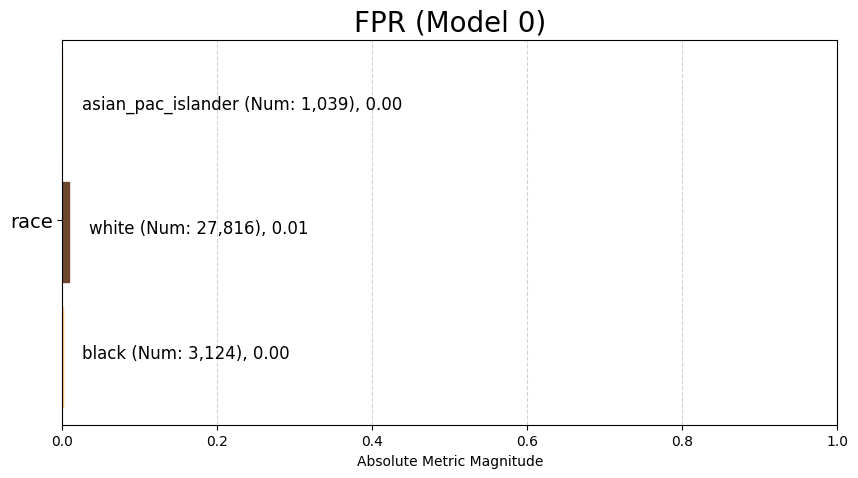

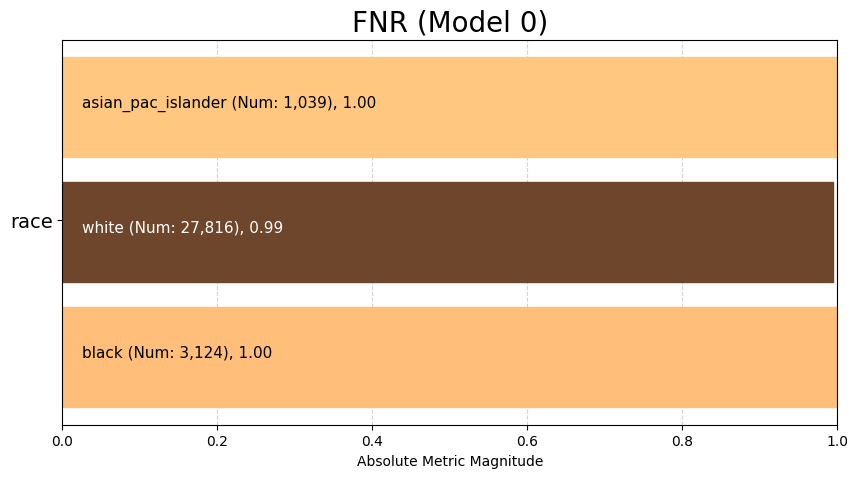

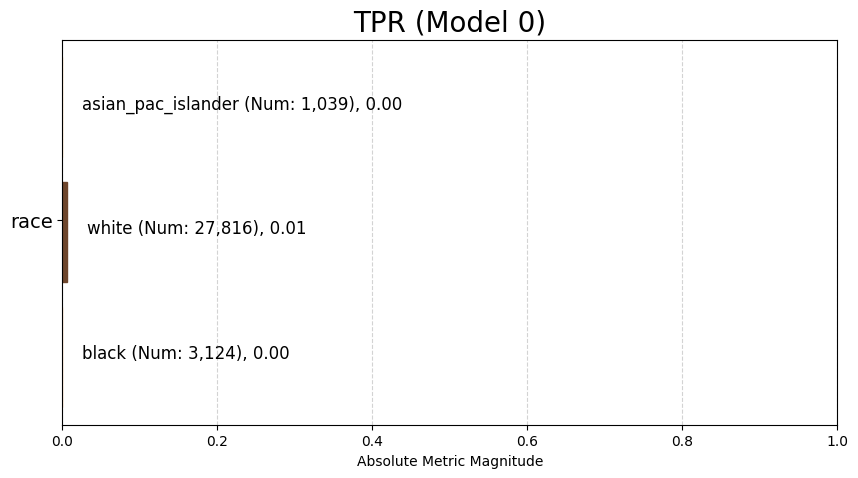

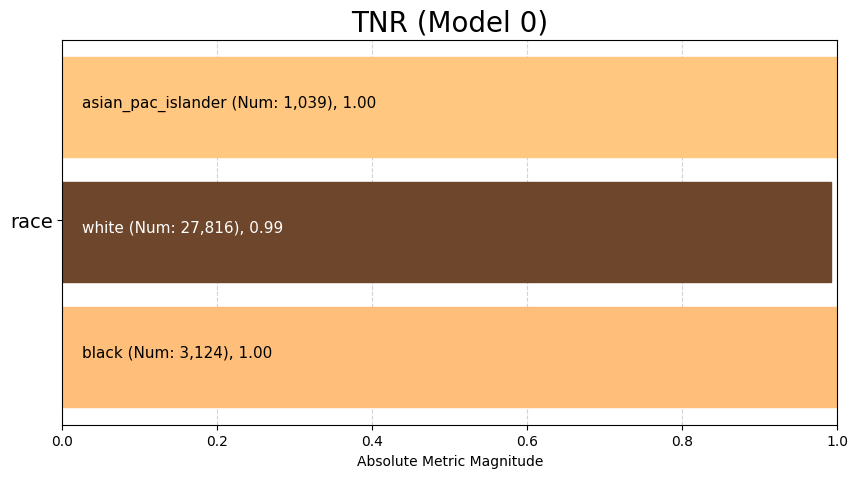

In [20]:
from aequitas.plotting import Plot

attribute_name = 'race'
crosstab_to_show = xtab[xtab['attribute_name'] == attribute_name]

aqp = Plot()
for metric in ['fpr', 'fnr', 'tpr', 'tnr']:
    fpr_plot = aqp.plot_group_metric(crosstab_to_show, metric, min_group_size=0.01)

_False Positive / False Negative / True Positive / True Negative rates across the racial groups_

#### Disparity per group

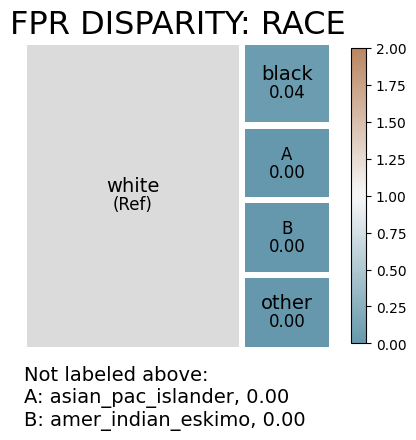

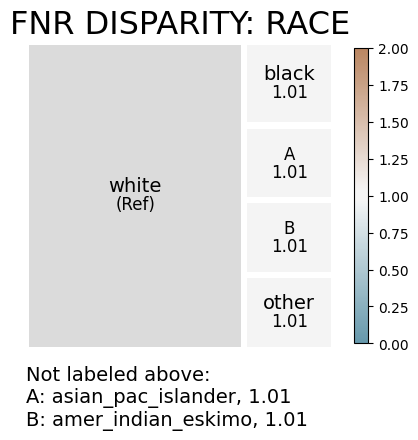

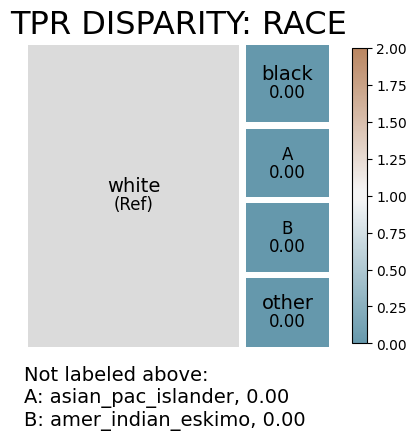

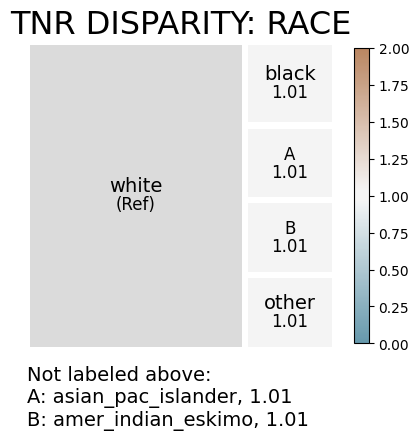

In [21]:
for metric in ['fpr', 'fnr', 'tpr', 'tnr']:
    fpr_disparity = aqp.plot_disparity(bias_df, group_metric=f'{metric}_disparity', attribute_name=attribute_name)

#### Fairness per group

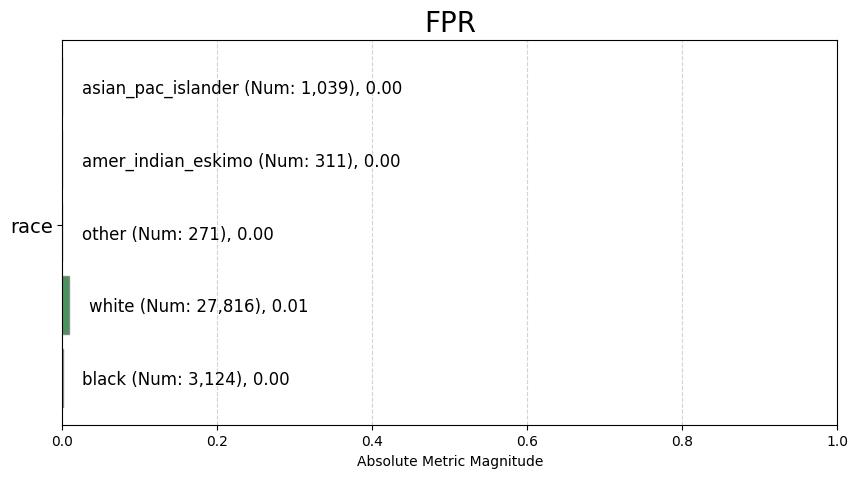

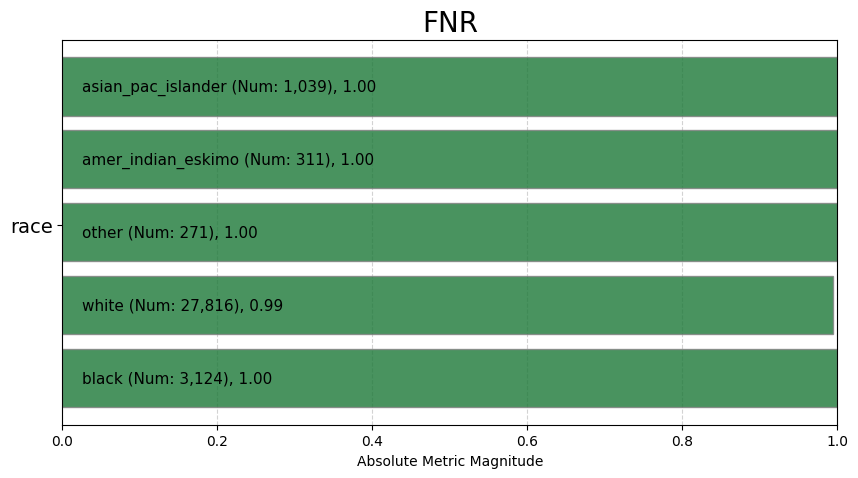

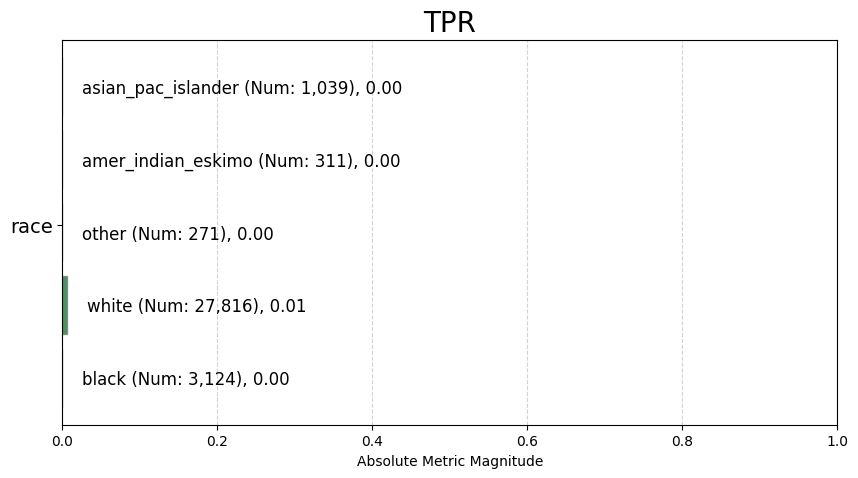

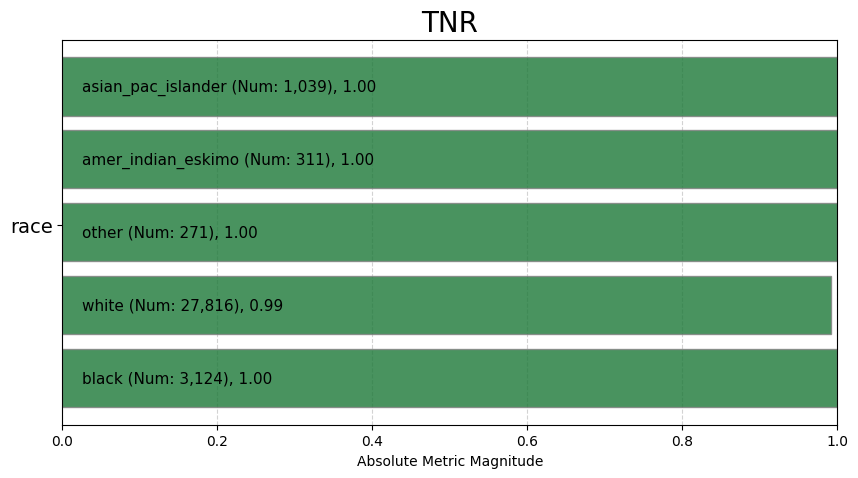

In [22]:
for metric in ['fpr', 'fnr', 'tpr', 'tnr']:
    fpr_fairness = aqp.plot_fairness_group(fair_df[fair_df['attribute_name'] == attribute_name], group_metric=metric, title=True)

#### Fairness disparity per group

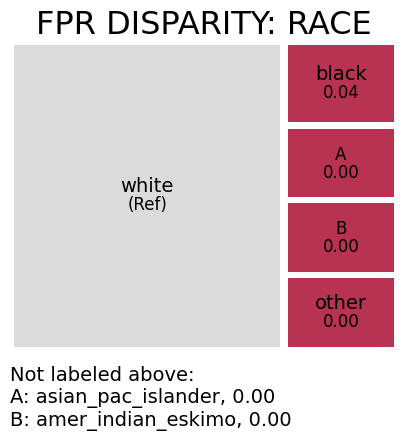

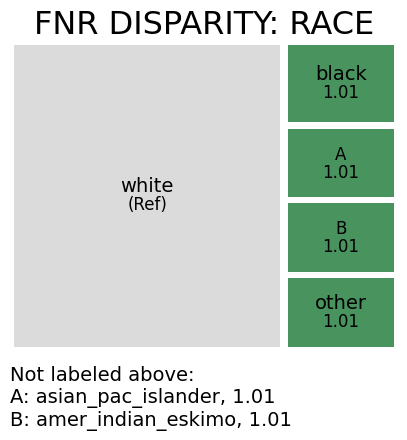

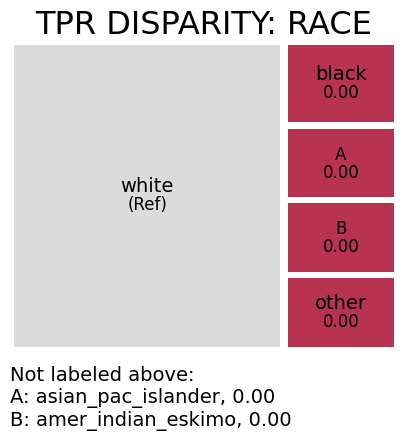

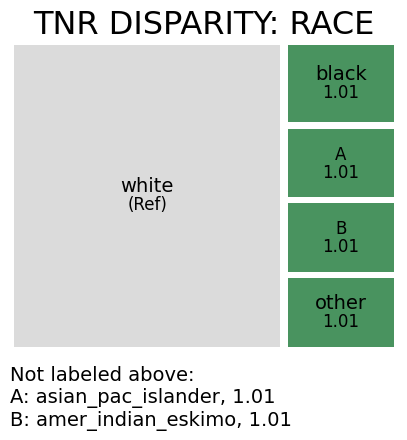

In [23]:
for metric in ['fpr', 'fnr', 'tpr', 'tnr']:
    fpr_disparity_fairness = aqp.plot_fairness_disparity(fair_df, group_metric=metric, attribute_name=attribute_name)